In [1]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
class Environment:
    def __init__(
            self,
            n_rows: int,
            n_cols: int,
            start: Tuple[int] = (2, 0),
            win_grid: Tuple[int] = (0, 3),
            lose_grid: Tuple[int] = (1, 3),
            wall_grids: List[Tuple] = []
            ) -> None:

        self.n_rows = n_rows
        self.n_cols = n_cols
        self.start = start
        self.win_grid = win_grid
        self.lose_grid = lose_grid
        self.wall_grids = wall_grids

        self.shape = (n_rows, n_cols)

        self.possible_actions = ('up', 'down', 'right', 'left')

        self.reward_matrix = np.zeros((n_rows, n_cols)) - 1

        self.reward_matrix[win_grid] = 10
        self.reward_matrix[lose_grid] = -10

        if len(wall_grids) > 0:
            for wall in wall_grids:
                self.reward_matrix[wall] = -5

        # make a dictionary of possible actions per state, where keys are a tuple of the states, values are the list of possible actions for the state.
        self.possible_actions_per_state = {}

        for i in range(n_rows):
            for j in range(n_cols):
                state = (i, j)

                func = lambda action: self.take_action(action, current_state=state) # returns a copy of take_action function that takes only one arguments
                possible_new_states = np.array(list(map(func, self.possible_actions)))

                is_valid_action = np.any(possible_new_states != np.array(state), axis=1) # bolean mask to filter

                possible_new_states = possible_new_states[is_valid_action] # filter valid possible new states
                possible_new_states = list(map(tuple, possible_new_states)) # change to list of tuples

                valid_actions = np.array(self.possible_actions)[is_valid_action] # filter actions that lead to valid possible new states
                valid_actions = list(valid_actions) # change to list

                self.possible_actions_per_state[state] = (valid_actions, possible_new_states)

    def take_action(self, action: str, current_state: Tuple) -> Tuple:

        if not isinstance(action, str):
            raise TypeError(f"Invalid action type. Expected action of type 'str', but got type '{type(action).__name__}'")

        action = action.lower()

        if action not in self.possible_actions:
            raise ValueError(f"Invalid action, expected any of {self.possible_actions} but got '{action}'")

        # # if current_state is not given, use the instance's state as the current state
        # if current_state is None:
        #     current_state = self.state

        if action == 'up':
            potential_state = (current_state[0] - 1, current_state[1])

        elif action == 'down':
            potential_state = (current_state[0] + 1, current_state[1])

        elif action == 'right':
            potential_state = (current_state[0], current_state[1] + 1)

        elif action == 'left':
            potential_state = (current_state[0], current_state[1] - 1)

        # update state if potential state is valid
        if potential_state not in self.wall_grids and \
        potential_state[0] in range(self.n_rows) and \
        potential_state[1] in range(self.n_cols):

            return potential_state

        return current_state

    def get_reward(self, state: Tuple) -> float|int:
        return self.reward_matrix[state]

    def is_terminal_state(self, current_state: Tuple) -> bool:
        if current_state == self.win_grid or current_state == self.lose_grid:
            return True
        return False

    def plot_environment(self) -> Tuple[plt.figure, plt.axes]:
        fig, ax = plt.subplots()

        # Add colored rectangles for start, win, and lose
        ax.add_patch(patches.Rectangle((self.start[1] - 0.5, self.start[0] - 0.5), 1, 1, color='lightblue'))
        ax.add_patch(patches.Rectangle((self.win_grid[1] - 0.5, self.win_grid[0] - 0.5), 1, 1, color='lightgreen'))
        ax.add_patch(patches.Rectangle((self.lose_grid[1] - 0.5, self.lose_grid[0] - 0.5), 1, 1, color='lightcoral'))

        for wall in self.wall_grids:
            ax.add_patch(patches.Rectangle((wall[1] - 0.5, wall[0] - 0.5), 1, 1, color='black'))

        # Annotate the start, win, and lose
        ax.text(self.start[1], self.start[0] + 0.2, 'S', ha='center', va='top', color='black', fontsize=10, fontweight='bold')
        ax.text(self.win_grid[1], self.win_grid[0] + 0.2, 'W', ha='center', va='top', color='black', fontsize=10, fontweight='bold')
        ax.text(self.lose_grid[1], self.lose_grid[0] + 0.2, 'L', ha='center', va='top', color='black', fontsize=10, fontweight='bold')

        # Set minor ticks at every grid line
        ax.set_xticks(np.arange(-0.5, self.n_cols, 1), minor=False)
        ax.set_yticks(np.arange(-0.5, self.n_rows, 1), minor=False)

        # Draw gridlines at the minor ticks
        ax.grid(visible=True, which='major', axis='both', color='black', linestyle='-', linewidth=1)

        # Optional: turn off tick labels and major ticks
        ax.tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)

        # Set axis limits
        ax.set_xlim(-0.5, self.n_cols - 0.5)
        ax.set_ylim(self.n_rows - 0.5, -0.5)

        return fig, ax

In [3]:
class Agent():
    def __init__(
            self,
            agent_env: Environment
            ) -> None:

        self.env = agent_env
        self.state = self.env.start

    def reset(self) -> None:
        self.state = self.env.start

    def choose_and_take_action(self, current_state: Tuple) -> Tuple:
        possible_new_states = self.env.possible_actions_per_state[current_state][1]

        if self.rand_gen.uniform(0, 1) <= self.exploration_rate: # random action
            return possible_new_states[self.rand_gen.choice(np.arange(len(possible_new_states)))]

        # else, use greedy policy for exploitation
        states_indexes = list(zip(*possible_new_states))
        return possible_new_states[np.argmax(self.V_values[*states_indexes])]

    def train(self,
            n_episodes: int,
            learning_rate: float = 0.2,
            discount_factor: float = 0.9,
            exploration_rate: float = 0.1,
            random_state: int|None = None
              ):

        self.lr = learning_rate
        self.gamma = discount_factor
        self.exploration_rate = exploration_rate

        self.rand_gen = np.random.RandomState(random_state)

        self.V_values = np.zeros(self.env.shape) # initialize V values to zeros

        # print(f"Starting state: {self.env.start}")
        for e in range(n_episodes):
            self.reset() # reset agent's state to the start state before training begins for each episode
            self.visited_states = [self.state] # list to hold all visited states

            number_of_visits = np.zeros(self.env.shape)
            number_of_visits[*self.state] = 1

            while not self.env.is_terminal_state(self.state):

                # change state by chosing and taking action
                self.state = self.choose_and_take_action(current_state=self.state)

                # keep track of visited states
                self.visited_states.append(self.state)

            G_return = 0

            # calaculate the G returns starting from the final state in the episode to the start state of the episode
            for i in range(len(self.visited_states) - 1, -1, -1):
                target_state = self.visited_states[i] # target state i

                G_return = self.env.get_reward(target_state) + self.gamma * G_return # G_{i - 1} = R_{i} + gamma * G_{i}

                number_of_visits[*target_state] += 1

                # incremental update: V(i) = V(i) + lr * (G(i)- V(i)) / N(i)
                self.V_values[*target_state] +=  self.lr * (G_return - self.V_values[*target_state]) / number_of_visits[*target_state]

            if (e + 1) % 5 == 0:
                print(f"Done with episode {e+1}")

    def get_policy_path(self, threshold:int = 50) -> List[Tuple]:
        path = [self.env.start]

        counter = 0 # to prevent infite loop if policy path is stuck in circles
        while not self.env.is_terminal_state(path[-1]) and counter < threshold:
            possible_next_states = self.env.possible_actions_per_state[path[-1]][1]
            argmax_value = np.argmax(self.V_values[*list(zip(*possible_next_states))])

            path.append(possible_next_states[argmax_value])

            counter += 1

        return path

    def plot_policy_path(self) -> None:
        # Create plot
        fig, ax = self.env.plot_environment()

        # Plot path step numbers
        for i, (r, c) in enumerate(self.get_policy_path()):
            ax.text(c, r, str(i), ha='center', va='center', color='blue', fontsize=12)

        fig.show()

#Try Some Cases

ENVIRONMENT WITHOUT AGENT

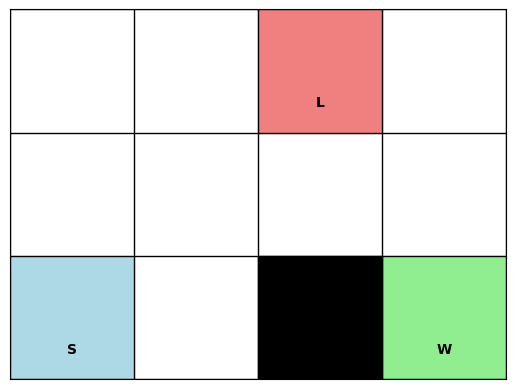

In [4]:
my_env = Environment(3, 4, win_grid=(2, 3), lose_grid=(0, 2), wall_grids=[(2, 2)])
my_env.plot_environment();

ENVIRONMENT WITH AGENT


CASE 1

In [5]:
my_agent = Agent(my_env)
my_agent.train(100, random_state=42)

Done with episode 5
Done with episode 10
Done with episode 15
Done with episode 20
Done with episode 25
Done with episode 30
Done with episode 35
Done with episode 40
Done with episode 45
Done with episode 50
Done with episode 55
Done with episode 60
Done with episode 65
Done with episode 70
Done with episode 75
Done with episode 80
Done with episode 85
Done with episode 90
Done with episode 95
Done with episode 100


In [6]:
my_env.reward_matrix

array([[ -1.,  -1., -10.,  -1.],
       [ -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -5.,  10.]])

In [7]:
my_agent.V_values

array([[-7.96388415, -5.93734323, -8.65782272,  3.19111333],
       [ 2.08095187,  3.43965106,  4.96018473,  7.777822  ],
       [ 0.62366073, -0.28133986,  0.        ,  9.99999998]])

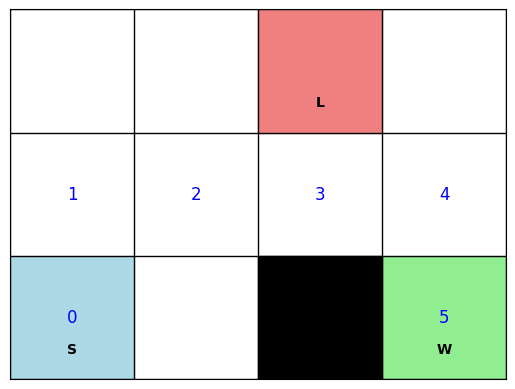

In [8]:
my_agent.plot_policy_path()

CASE 2

In [10]:
my_env = Environment(3, 4, win_grid=(0, 3), lose_grid=(1, 3), wall_grids=[(1, 1)])
my_agent = Agent(my_env)
my_agent.train(100, random_state=42)

Done with episode 5
Done with episode 10
Done with episode 15
Done with episode 20
Done with episode 25
Done with episode 30
Done with episode 35
Done with episode 40
Done with episode 45
Done with episode 50
Done with episode 55
Done with episode 60
Done with episode 65
Done with episode 70
Done with episode 75
Done with episode 80
Done with episode 85
Done with episode 90
Done with episode 95
Done with episode 100


In [11]:
my_agent = Agent(my_env)
my_agent.train(100, random_state=42)

Done with episode 5
Done with episode 10
Done with episode 15
Done with episode 20
Done with episode 25
Done with episode 30
Done with episode 35
Done with episode 40
Done with episode 45
Done with episode 50
Done with episode 55
Done with episode 60
Done with episode 65
Done with episode 70
Done with episode 75
Done with episode 80
Done with episode 85
Done with episode 90
Done with episode 95
Done with episode 100


In [12]:
my_agent.V_values

array([[ 4.47462083,  6.17197756,  7.98456637, 10.        ],
       [ 3.01410965,  0.        ,  3.76711943, -2.        ],
       [ 1.54202466,  0.5754674 ,  2.00492557,  1.12392   ]])

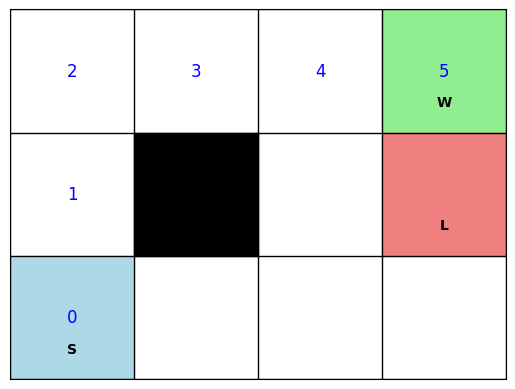

In [13]:
my_agent.plot_policy_path()

CASE 3

In [14]:
my_env2 = Environment(
    10,
    10,
    start=(9, 0),
    win_grid=(1, 7),
    lose_grid=(2, 9),
    wall_grids=[
        (7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (1, 4), (2, 4), (3, 4), (4, 4), (5, 4), (4, 5), (4, 6), (4, 7), (4, 8)
        ]
    )
my_agent2 = Agent(my_env2)
my_agent2.train(100, exploration_rate=0.7, random_state=42,)

Done with episode 5
Done with episode 10
Done with episode 15
Done with episode 20
Done with episode 25
Done with episode 30
Done with episode 35
Done with episode 40
Done with episode 45
Done with episode 50
Done with episode 55
Done with episode 60
Done with episode 65
Done with episode 70
Done with episode 75
Done with episode 80
Done with episode 85
Done with episode 90
Done with episode 95
Done with episode 100


In [16]:
my_env2.reward_matrix

array([[ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -5.,  -1.,  -1.,  10.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -5.,  -1.,  -1.,  -1.,  -1., -10.],
       [ -1.,  -1.,  -1.,  -1.,  -5.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -5.,  -5.,  -5.,  -5.,  -5.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -5.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -5.,  -5.,  -5.,  -5.,  -5.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.],
       [ -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.]])

In [17]:
my_agent2.V_values

array([[-8.34962871, -8.49612824, -6.69482939, -3.46410996, -1.2088072 ,
         1.39092211,  4.11153852,  2.1586112 , -4.16755994, -2.06944992],
       [-8.61176145, -9.05986908, -5.89857497, -5.28923664,  0.        ,
         1.84382274,  6.70754237,  9.99995323, -0.99744447, -3.94432252],
       [-8.81702586, -9.13858722, -6.25414223, -7.41115951,  0.        ,
         1.92841329,  3.15152243,  0.16513554, -3.41286561, -9.99956444],
       [-9.28435255, -7.25935994, -7.43090897, -8.20349518,  0.        ,
         0.35041055, -0.2792806 , -3.47439276, -4.15570104, -8.27054123],
       [-9.59959179, -8.54293649, -8.60071366, -8.7619721 ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        , -8.71481433],
       [-9.69970357, -8.87133229, -9.18309623, -9.46237915,  0.        ,
        -9.89234419, -9.82389661, -9.48729769, -9.22544644, -9.36032393],
       [-9.61289264, -9.75142893, -9.68041955, -9.49949428, -9.50783461,
        -9.90468439, -9.61751987, -9.61606   

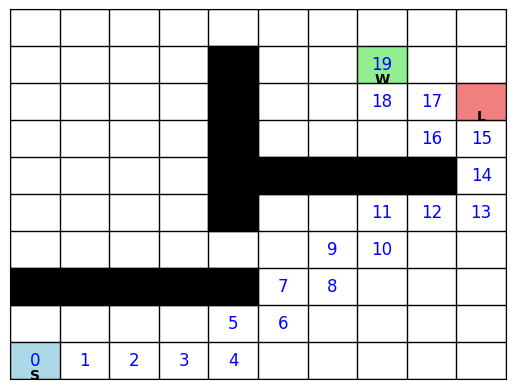

In [15]:
my_agent2.plot_policy_path()